# Neighborhoods question
Q (from a meeting agenda Bloomberg_ Gun Violence Dashboard_ Meeting 2 Agenda.docx): 
```
Final Neighborhood Questions:
1. Not duplicating MSU Project Green Light (PGL) study, what new can we learn from PGL data that give insight to where interventions should be targeted?
2. Are there specific locations/ property types that become magnets for gun violence incidents?
3. What can we find unique to areas/ blocks where we see highest event rates (presence of empty lots, convenience stores, gas stations, bus stops, schools, etc)?
```

If we're looking to identify where interventions should be targeted... Detroit has the gun violence rates, so the clearly correct thing to do is target interventions where gun violence rates are high.

Another way of viewing this question is to inform policy choices (change characteristics based on correlations and hope it's causal). This would require _way_ more work than we have time for

In [257]:
import geopandas as gpd

from features.income import Income
from features.violence_calls import ViolenceCalls
from features.households import Households
from features.population import Population
from features.population_density import PopulationDensity
from features.feature_constructor import Feature
from features.out_of_state_rental_ownership import OutOfStateRentalOwnership
from features.ddot_bus_stops import DDotBusStops
from features.smart_bus_stops import SmartBusStops
from features.rental_statuses import RentalStatuses
from features.project_green_light_locations import ProjectGreenlightLocations
from util_detroit import concatenate_features

from detroit_geos import get_detroit_census_geos, get_detroit_boundaries

import patsy
from patsy import dmatrices, dmatrix
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.impute import SimpleImputer

In [2]:
# Fetch geometries for visualization

tracts = get_detroit_census_geos(decennial_census_year=2010,target_geo_grain='tract',).set_index('geo_id')
detroit = get_detroit_boundaries()
block = get_detroit_census_geos(decennial_census_year=2010,target_geo_grain='block').set_index('geo_id')

# Build Features

In [258]:
target_geo_grain = "tract"
feature_objects = [
    Population(
        decennial_census_year=2010, population_data_path="population", verbose=False
    ),
    PopulationDensity(
        decennial_census_year=2010,
        population_data_path="population",
    ),
    ViolenceCalls(decennial_census_year=2010, verbose=False),
    Income(verbose=False),
    Households(),
    OutOfStateRentalOwnership(2010),
    DDotBusStops(decennial_census_year=2010),
    SmartBusStops(decennial_census_year=2010),
    RentalStatuses(decennial_census_year=2010),
    ProjectGreenlightLocations(decennial_census_year=2010),
]
feat_df = concatenate_features(feature_objects,'tract')

# Transform

In [286]:
from munge_features import transform_1
df = transform_1(feat_df)

In [260]:
formula_bones = "call_rate ~ " + '\n+ '.join([x for x in df.columns if ('call_rate' not in x)])
formula = formula_bones.replace('per_household_income','np.log(per_household_income)')
y, X = dmatrices(
    formula_like=formula,
    data=df,
    return_type="dataframe",
)
D = dmatrix(
    formula_like=formula.replace('~','+'),
    data=df,
    return_type="dataframe",
)

In [283]:
colname_map = dict(
    zip(
        r2.index,
        [
            "People per household",
            "proportion of rental units owned out of state",
            "rental units per sq km",
            "gleenlight locations/km^2",
            "bus stops /km^2",
            "population density",
            "log income",
            "proportion of households married",
        ],
    )
)

In [285]:
r2.to_clipboard()

In [274]:
r2 = (D.corr()**2).call_rate.sort_values()


# Run regressions

In [277]:
y, X = dmatrices(
    formula_like=formula,
    data=df,
    return_type="dataframe",
)
mdl = sm.OLS(endog=y,exog=X)
res = mdl.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              call_rate   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     14.96
Date:                Wed, 02 Mar 2022   Prob (F-statistic):           9.87e-19
Time:                        20:50:33   Log-Likelihood:                -89.441
No. Observations:                 341   AIC:                             196.9
Df Residuals:                     332   BIC:                             231.4
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         1.3880      0.690      2.011      0.045       0.030       2.746
population_density               -0.0001   3.61e-05     -3.575      0.000      -0.000    -5.8e-05
np.log(per_household_income)     -0.0723      0.063     -1.146      0.253      -0.196       0.052
out_of_state_rental_ownership     0.2905      0.144      2.013      0.045       0.007       0.574
married_household_prop           -0.8014      0.161     -4.985      0.000      -1.118      -0.485
rental_density                    0.0003      0.000      1.860      0.064   -1.99e-05       0.001
bus_density                       0.0002      0.000      0.472      0.637      -0.001       0.001
greenlight_density                0.0041      0.001      2.850      0.005       0.001       0.007
people_per_household              0.0193      0.025      0.781      0.435      -0.029       0.068
==============================================================================
Omnibus:                      470.877   Durbin-Watson:                   1.579
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            85666.123
Skew:                           6.530   Prob(JB):                         0.00
Kurtosis:                      79.542   Cond. No.                     5.42e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.42e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [252]:
y, X = dmatrices(
    formula_like=formula,
    data=df,
    return_type="dataframe",
)
# exposure = X.pop('population')
mdl = sm.GLM(endog=y,exog=X,family=sm.families.Poisson())
res = mdl.fit()

res.summary()
res = mdl.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              call_rate   No. Observations:                  341
Model:                            GLM   Df Residuals:                      332
Model Family:                 Poisson   Df Model:                            8
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -242.69
Date:                Wed, 02 Mar 2022   Deviance:                       52.806
Time:                        13:38:14   Pearson chi2:                     60.9
No. Iterations:                     5   Pseudo R-squ. (CS):            0.08364
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         0.4649      3.308      0.141      0.888      -6.018       6.948
population_density               -0.0003      0.000     -1.761      0.078      -0.001    3.59e-05
np.log(per_household_income)     -0.0715      0.311     -0.230      0.818      -0.682       0.539
out_of_state_rental_ownership     0.7246      0.596      1.216      0.224      -0.444       1.893
married_household_prop           -2.8160      0.945     -2.981      0.003      -4.667      -0.965
rental_density                    0.0010      0.001      1.292      0.196      -0.001       0.002
bus_density                      -0.0002      0.002     -0.116      0.907      -0.003       0.003
greenlight_density                0.0053      0.005      1.153      0.249      -0.004       0.014
people_per_household              0.0515      0.106      0.488      0.626      -0.155       0.258
=================================================================================================
"""

# Compare impact of granularity

In [289]:
mdl = {}
res = {}
for target_geo_grain in ("block","block group","tract"):
    feat_df = concatenate_features(feature_objects,target_geo_grain)
    df = transform_1(feat_df)
    y, X = dmatrices(
        formula_like=formula,
        data=df,
        return_type="dataframe",
    )
    mdl[target_geo_grain] = sm.OLS(endog=y,exog=X)
    res[target_geo_grain] = mdl[target_geo_grain].fit()
    res[target_geo_grain].summary()

In [299]:
dir(res[target_geo_grain])#.params

['HC0_se',
 'HC1_se',
 'HC2_se',
 'HC3_se',
 '_HCCM',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abat_diagonal',
 '_cache',
 '_data_attr',
 '_data_in_cache',
 '_get_robustcov_results',
 '_is_nested',
 '_use_t',
 '_wexog_singular_values',
 'aic',
 'bic',
 'bse',
 'centered_tss',
 'compare_f_test',
 'compare_lm_test',
 'compare_lr_test',
 'condition_number',
 'conf_int',
 'conf_int_el',
 'cov_HC0',
 'cov_HC1',
 'cov_HC2',
 'cov_HC3',
 'cov_kwds',
 'cov_params',
 'cov_type',
 'df_model',
 'df_resid',
 'diagn',
 'eigenvals',
 'el_test',
 'ess',
 'f_pvalue',
 'f_test',
 'fittedvalues',
 'fvalue',
 'get_influence',
 'get_prediction',
 'get_robustcov_results',
 'info_c

In [320]:
res['block group'].conf_int()

,0,1
Intercept,0.967753,2.730049
population_density,-0.000125,-0.000046
np.log(per_household_income),-0.196128,-0.028101
out_of_state_rental_ownership,0.097762,0.352427
married_household_prop,-0.838216,-0.411278
rental_density,-0.000583,0.001865
bus_density,0.000696,0.004982
greenlight_density,0.018573,0.034731
people_per_household,-0.074605,0.004508


In [330]:
print(res['block group'].conf_int())

                                      0         1
Intercept                      0.967753  2.730049
population_density            -0.000125 -0.000046
np.log(per_household_income)  -0.196128 -0.028101
out_of_state_rental_ownership  0.097762  0.352427
married_household_prop        -0.838216 -0.411278
rental_density                -0.000583  0.001865
bus_density                    0.000696  0.004982
greenlight_density             0.018573  0.034731
people_per_household          -0.074605  0.004508


In [332]:
g = 'block group'

In [337]:
t = res[g]
t.conf_int()

In [338]:
res[g].params

Intercept                        1.848901
population_density              -0.000086
np.log(per_household_income)    -0.112115
out_of_state_rental_ownership    0.225095
married_household_prop          -0.624747
rental_density                   0.000641
bus_density                      0.002839
greenlight_density               0.026652
people_per_household            -0.035048
dtype: float64

In [353]:
np.sort(res[g].get_influence().influence)

array([-0.12171075, -0.097297  , -0.04411435, ...,  0.18832944,
        0.2312145 ,  1.0901371 ])

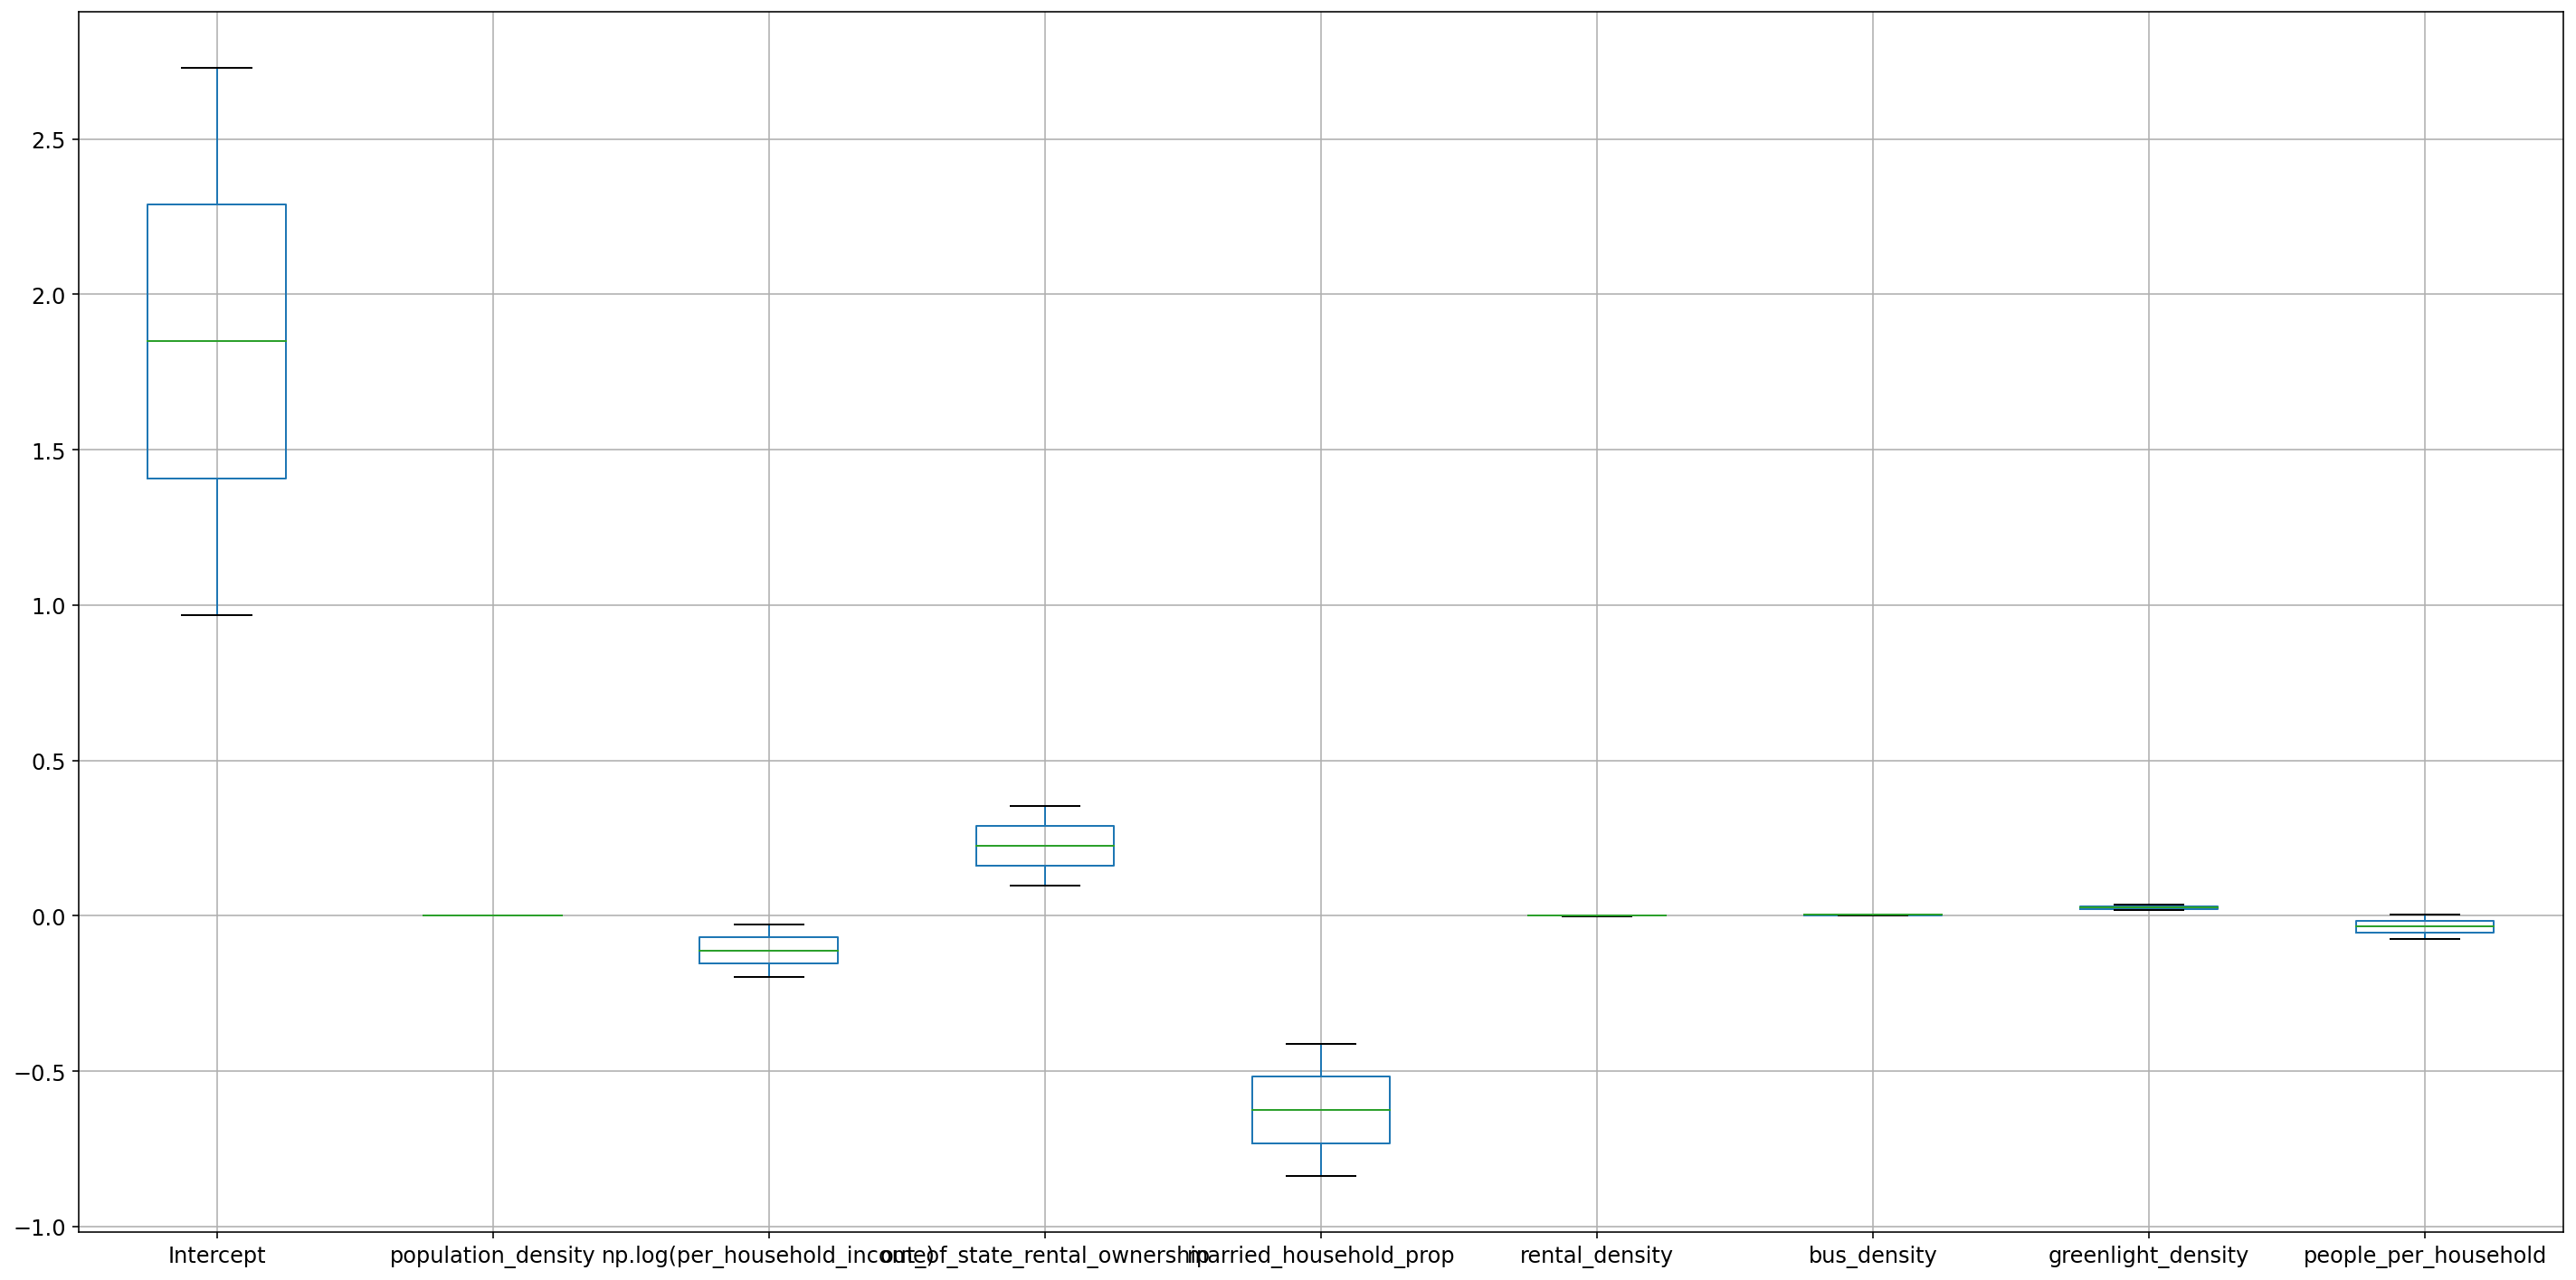

In [358]:
fig, ax = plt.subplots(1,1,figsize=(20,10))
pd.concat((res[g].conf_int().rename(columns={0:.025,1:.975}),res[g].params.rename(0.5)),axis=1).T.boxplot(ax=ax)
plt.tight_layout()

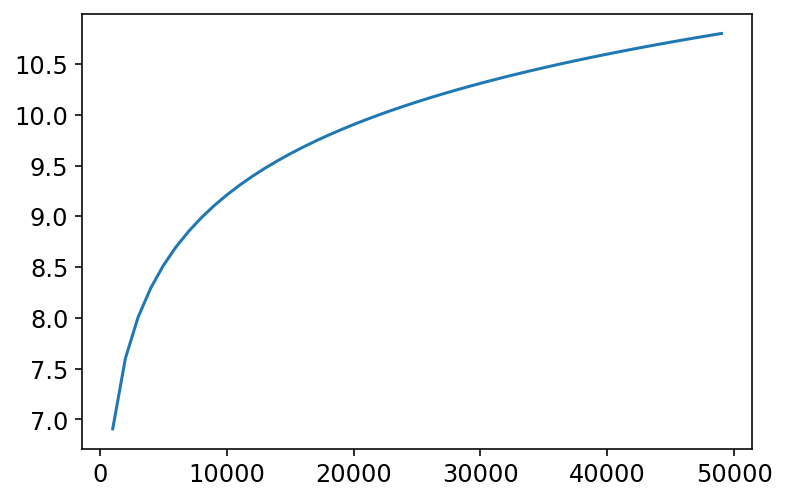

In [365]:
x = np.arange(1000,50e3,1e3)
plt.plot(x,np.log(x))

In [371]:
np.exp(1)

2.718281828459045

In [363]:
np.log(10)

2.302585092994046

In [334]:
_ = [print(g + '\n'+str(res[g].params) + str(res[g].conf_int()) + '\n\n') for g in res.keys()]
#       + res[g].conf_int()

block
Intercept                        0.842983
population_density              -0.000040
np.log(per_household_income)    -0.027029
out_of_state_rental_ownership    0.178770
married_household_prop          -0.393034
rental_density                  -0.009773
bus_density                      0.380811
greenlight_density               0.948863
people_per_household            -0.180870
dtype: float64                                      0         1
Intercept                      0.149852  1.536114
population_density            -0.000051 -0.000029
np.log(per_household_income)  -0.093851  0.039794
out_of_state_rental_ownership  0.118698  0.238842
married_household_prop        -0.568139 -0.217930
rental_density                -0.024843  0.005297
bus_density                    0.267167  0.494455
greenlight_density             0.612051  1.285674
people_per_household          -0.329245 -0.032494


block group
Intercept                        1.848901
population_density              -0.000086
np.l